In [1]:
pip install ipywidgets

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 139 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 15.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.10.2/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# %%
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import random
import time # 导入 time 模块

In [2]:
# ## 2. 加载数据和映射关系 (Load Data and Mappings)
#
# - 从 "tang.npz" 文件加载数据。
# - 提取诗歌数据、词到索引的映射 (word2ix) 和索引到词的映射 (ix2word)。


tang_file = np.load("tang.npz", allow_pickle=True)

data = tang_file['data']
word2ix = tang_file['word2ix'].item()
idx2word = tang_file['ix2word'].item()

print("数据和映射关系加载完成。")
print(f"word2ix 类型: {type(word2ix)}")
print(f"idx2word 类型: {type(idx2word)}")
print(f"共有 {len(data)} 首诗。")

数据和映射关系加载完成。
word2ix 类型: <class 'dict'>
idx2word 类型: <class 'dict'>
共有 57580 首诗。


In [3]:
# ## 3. `idx2poem` 函数定义与示例 (idx2poem Function and Example)
#
# - 定义将索引序列转换为诗歌文本的函数。
# - 打印一首示例诗歌及其特殊标记的索引。

# %%
def idx2poem(idx_poem_list):
    poem_chars = []
    for id_val in idx_poem_list:
        poem_chars.append(idx2word.get(id_val, '<unk>')) # 使用 .get() 以防索引不存在
    return "".join(poem_chars)

print(f"示例诗歌 (data[314]): {idx2poem(data[314])}")

# 确保 word2ix 和 '</s>' 键存在
if '</s>' in word2ix:
    print(f"</s> 对应的索引: {word2ix['</s>']}")
else:
    print("警告: 词典 word2ix 中未找到 '</s>'。")

示例诗歌 (data[314]): </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><START>南楼夜已寂，暗鸟动林间。不见城郭事，沈沈唯四山。<EOP>
</s> 对应的索引: 8292


In [4]:
# ## 4. 诗歌数据预处理 (Poem Preprocessing)
#
# - 移除每首诗歌开头的 `</s>` 标记。
# - 打印处理后的第一首诗歌作为示例。
# - 打印词汇表大小。

# %%
poems = []
for poem_indices in data:
    start_index = 0
    if '</s>' not in word2ix: # 检查 '</s>' 是否在词典中
        print("错误: '</s>' 不在 word2ix 中，无法处理诗歌数据。将跳过预处理。")
        poems = data # 或者采取其他错误处理方式
        break
    for index, ix in enumerate(poem_indices):
        if ix == word2ix["</s>"]:
            continue
        else:
            start_index = index
            break
    poems.append(poem_indices[start_index:])

if poems:
    print(f"处理后的第一首诗 (索引): {poems[0]}")
    print(f"处理后的第一首诗 (文本): {idx2poem(poems[0])}")
else:
    print("警告: 处理后诗歌列表为空。")

print(f"词汇表大小: {len(idx2word)}")

处理后的第一首诗 (索引): [8291 6731 4770 1787 8118 7577 7066 4817  648 7121 1542 6483 7435 7686
 2889 1671 5862 1949 7066 2596 4785 3629 1379 2703 7435 6064 6041 4666
 4038 4881 7066 4747 1534   70 3788 3823 7435 4907 5567  201 2834 1519
 7066  782  782 2063 2031  846 7435 8290]
处理后的第一首诗 (文本): <START>度门能不访，冒雪屡西东。已想人如玉，遥怜马似骢。乍迷金谷路，稍变上阳宫。还比相思意，纷纷正满空。<EOP>
词汇表大小: 8293


In [5]:
# ## 5. 创建输入输出序列 (Create Input-Output Sequences)
#
# - 将所有诗歌连接成一个长序列。
# - 按指定的序列长度 (`seq_len`) 切割成长序列，生成模型的输入 (`X`) 和目标 (`Y`)。

# %%
seq_len = 48
X = []
Y = []
poems_data = [j for i in poems for j in i]

if len(poems_data) <= seq_len :
    print(f"错误: poems_data 的长度 ({len(poems_data)}) 不足以创建长度为 {seq_len} 的序列。")
    print("请检查数据预处理步骤或减少 seq_len。")
else:
    for i in range(0, len(poems_data) - seq_len - 1, seq_len):
        X.append(poems_data[i:i + seq_len])
        Y.append(poems_data[i + 1:i + seq_len + 1])

    print(f"创建的 X 序列数量: {len(X)}")
    print(f"创建的 Y 序列数量: {len(Y)}")

创建的 X 序列数量: 65260
创建的 Y 序列数量: 65260


In [6]:
# ## 6. 定义PyTorch数据集 (Define PyTorch Dataset)
#
# - 创建一个自定义的 `Dataset` 类来包装我们的 `X` 和 `Y` 数据。

# %%
class PoemDataset(Dataset):
    def __init__(self, X_data, Y_data):
        self.X = X_data
        self.Y = Y_data
        self.len = len(X_data)

    def __getitem__(self, index):
        x_np = np.array(self.X[index])
        y_np = np.array(self.Y[index])
        return torch.from_numpy(x_np).long(), torch.from_numpy(y_np).long()

    def __len__(self):
        return self.len

if not X or not Y:
    print("错误：X 或 Y 序列为空。后续单元格可能无法正确执行。")
else:
    print("PoemDataset 类定义完成。")

PoemDataset 类定义完成。


In [8]:
# ## 7. 创建数据加载器 (Create DataLoader)
#
# - 使用 `PoemDataset` 和指定的 `batch_size` 创建一个 `DataLoader`。
# - 从 `DataLoader` 中取一个批次的数据进行形状检查。

# %%
if not X or not Y:
    print("由于 X 或 Y 为空，无法创建 DataLoader。请检查前面的步骤。")
else:
    data_loader = DataLoader(PoemDataset(X, Y), batch_size=128, num_workers=0, shuffle=True)
    print("DataLoader 创建完成。")

    if len(data_loader) > 0:
        a, b = next(iter(data_loader))
        print(f"数据加载器输出的批次形状 (输入): {a.shape}")
        print(f"数据加载器输出的批次形状 (目标): {b.shape}")
    else:
        print("错误: DataLoader 为空，无法获取批次数据。")

DataLoader 创建完成。
数据加载器输出的批次形状 (输入): torch.Size([128, 48])
数据加载器输出的批次形状 (目标): torch.Size([128, 48])


In [9]:
# ## 8. 定义模型 (`PoemNet`) (Define the Model)
#
# - 定义包含 Embedding 层、LSTM 层和全连接层的神经网络模型。

# %%
class PoemNet(nn.Module):
    def __init__(self, vocab_size_param, embedding_dim_param, hidden_dim_param): # 参数名加后缀以示区分
        super(PoemNet, self).__init__()
        self.embeddings = nn.Embedding(vocab_size_param, embedding_dim_param)
        self.lstm = nn.LSTM(embedding_dim_param, hidden_dim_param, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim_param, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, 4096),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(4096, vocab_size_param)
        )

    def forward(self, input_seq, hidden=None):
        embedded = self.embeddings(input_seq)
        lstm_out, hidden = self.lstm(embedded, hidden)
        output = self.fc(lstm_out)
        return output, hidden

print("PoemNet 模型类定义完成。")

PoemNet 模型类定义完成。


In [10]:
# ## 9. 模型实例化与设置 (Instantiate Model and Setup)
#
# - 设置词汇表大小、嵌入维度和隐藏层维度等超参数。
# - 确定运行设备 (CPU 或 GPU)。
# - 实例化模型，并将其移动到指定设备。
# - 定义优化器和损失函数。

# %%
vocab_size = len(idx2word.keys())
embedding_dim = 200
hidden_dim = 1024

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")

my_net = PoemNet(vocab_size, embedding_dim, hidden_dim).to(device)
print("\n模型结构:")
print(my_net)

optimizer = optim.Adam(my_net.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

print("\n模型、优化器和损失函数已设置。")

使用的设备: cuda:0

模型结构:
PoemNet(
  (embeddings): Embedding(8293, 200)
  (lstm): LSTM(200, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=2048, out_features=4096, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=8293, bias=True)
  )
)

模型、优化器和损失函数已设置。


In [11]:
# ## 10. 定义诗歌生成函数 (Define Poem Generation Function)
#
# - `generate_poem_sample` 函数用于在训练后或训练过程中生成诗歌样本。

# %%
def generate_poem_sample(model, start_words_str, max_len=100, temperature=0.7):
    model.eval() # 切换到评估模式
    with torch.no_grad(): # 关闭梯度计算
        hidden = None
        unk_idx = word2ix.get('<unk>')
        if unk_idx is None:
            print("警告: 词典中没有 '<unk>' 标记。如果起始词未知，可能会选择词典中的第一个词。")
            # Fallback: use the first word from word2ix if start_words_str is unknown
            if not word2ix: # 确保 word2ix 不是空的
                 print("错误: word2ix 词典为空，无法获取备用词。")
                 return "错误: word2ix 词典为空。"
            first_word_in_dict = next(iter(word2ix.keys()))
            unk_idx = word2ix.get(first_word_in_dict)


        input_seq = [word2ix.get(word, unk_idx) for word in start_words_str]

        if not start_words_str or all(word not in word2ix for word in start_words_str):
            print("警告: 起始词为空或所有词均未在词典中找到，将使用随机词开始。")
            if not ix2word:
                print("错误: ix2word 为空，无法选择随机起始词。")
                return "错误: ix2word 为空。"
            random_start_idx = random.choice(list(ix2word.keys()))
            input_seq = [random_start_idx]

        input_tensor = torch.tensor([input_seq]).long().to(device) # 确保 device 在此作用域内可用
        generated_poem_indices = list(input_seq)

        end_token_indices = {word2ix.get('</s>', -1), word2ix.get('<EOP>', -1)}
        end_token_indices.discard(-1) # 移除-1 (如果 '</s>' 或 '<EOP>' 不存在)

        for _ in range(max_len):
            output, hidden = model(input_tensor, hidden)
            last_word_logits = output[0, -1, :] / temperature
            probabilities = F.softmax(last_word_logits, dim=0)
            next_word_idx = torch.multinomial(probabilities, 1).item()

            if end_token_indices and next_word_idx in end_token_indices:
                break

            generated_poem_indices.append(next_word_idx)
            input_tensor = torch.cat((input_tensor, torch.tensor([[next_word_idx]]).long().to(device)), dim=1)
            if input_tensor.size(1) > seq_len: # 保持输入序列长度与训练时类似
                 input_tensor = input_tensor[:, -seq_len:]
        return "".join([ix2word.get(idx, '<unk>') for idx in generated_poem_indices])

print("generate_poem_sample 函数定义完成。")


generate_poem_sample 函数定义完成。


开始训练，共 30 个 epochs...
Epoch [1/30], Step [50/510], Loss: 6.4124
Epoch [1/30], Step [100/510], Loss: 6.0303
Epoch [1/30], Step [150/510], Loss: 6.0111
Epoch [1/30], Step [200/510], Loss: 5.9182
Epoch [1/30], Step [250/510], Loss: 5.8588
Epoch [1/30], Step [300/510], Loss: 5.7888
Epoch [1/30], Step [350/510], Loss: 5.7139
Epoch [1/30], Step [400/510], Loss: 5.5855
Epoch [1/30], Step [450/510], Loss: 5.5092
Epoch [1/30], Step [500/510], Loss: 5.4576
Epoch [1/30] 完成, 平均损失: 5.9678, 本Epoch用时: 301.54 秒
--------------------------------------------------
Epoch [2/30], Step [50/510], Loss: 5.3378
Epoch [2/30], Step [100/510], Loss: 5.2858
Epoch [2/30], Step [150/510], Loss: 5.3038
Epoch [2/30], Step [200/510], Loss: 5.2488
Epoch [2/30], Step [250/510], Loss: 5.2911
Epoch [2/30], Step [300/510], Loss: 5.1574
Epoch [2/30], Step [350/510], Loss: 5.1588
Epoch [2/30], Step [400/510], Loss: 5.1630
Epoch [2/30], Step [450/510], Loss: 5.1011
Epoch [2/30], Step [500/510], Loss: 4.9909
Epoch [2/30] 完成, 平均

/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPyt

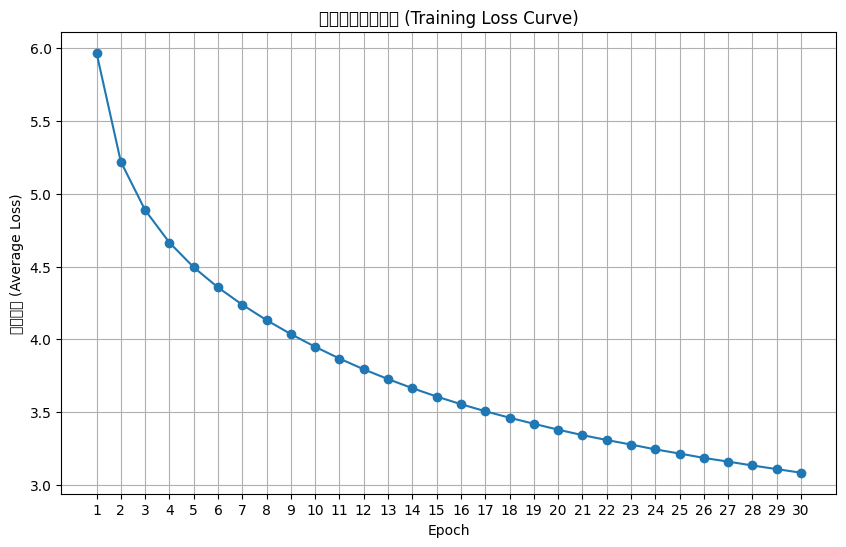

In [12]:
# ## 11. 训练模型 (Train the Model)
#
# - 设置训练的总轮数 (`num_epochs`)。
# - 迭代训练数据，计算损失，反向传播并更新模型参数。
# - 打印每个 epoch 的平均损失和用时。
# - 训练完成后绘制损失变化曲线。

# %%%
import matplotlib.pyplot as plt # Import matplotlib for plotting
import time

num_epochs = 30
print(f"开始训练，共 {num_epochs} 个 epochs...")

total_training_start_time = time.time()
epoch_losses = [] # List to store average loss for each epoch

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    my_net.train() # 设置为训练模式
    total_loss_epoch = 0 # Accumulator for total loss in this epoch

    for i, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = my_net(inputs)
        loss = loss_function(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss_epoch += loss.item()

        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    # Ensure data_loader is not empty before division
    avg_loss_epoch = total_loss_epoch / len(data_loader) if len(data_loader) > 0 else float('inf')
    epoch_losses.append(avg_loss_epoch) # Store the average loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] 完成, 平均损失: {avg_loss_epoch:.4f}, 本Epoch用时: {epoch_duration:.2f} 秒')
    print("-" * 50)

total_training_end_time = time.time()
total_training_duration = total_training_end_time - total_training_start_time
print("训练完成!")
print(f"总训练用时: {total_training_duration:.2f} 秒")

# Plotting the loss curve
# Check if epoch_losses is not empty before plotting
if epoch_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
    plt.title('训练损失变化曲线 (Training Loss Curve)')
    plt.xlabel('Epoch')
    plt.ylabel('平均损失 (Average Loss)')
    plt.grid(True)
    plt.xticks(range(1, len(epoch_losses) + 1)) # Ensure x-ticks match epochs
    plt.show()
else:
    print("未能记录损失，无法绘制曲线。请检查训练循环。")

In [13]:
# ## 12. 保存模型 (Save the Model)
#
# - 将训练好的模型的状态字典保存到文件。

# %%
torch.save(my_net,"model.h5")
print("模型已保存到model.h5")

模型已保存到model.h5


In [14]:
# 由于整个模型太大，无法从华为云下载，尝试只保存权重
model_save_path = "poem_model_final_jupyter.pth"
torch.save(my_net.state_dict(), model_save_path)
print(f"模型已保存到 {model_save_path}")

模型已保存到 poem_model_final_jupyter.pth


权重大小依旧超过100mb，无法下载，遂放弃